# Digital Data Collection Methods: Opportunities and Risks 
## Winter 2024

## Final Project
# An analysis of food prices and minimum wage in USA

## Mehmet Sundu, Aizhan Borubaeva, Ekaterina Lobanchenko

The minimum wage serves as a crucial economic foundation in the United States, aiming to guarantee that individuals in low-wage positions can maintain a minimum standard of living. Nevertheless, an ongoing discussion surrounds whether the minimum wage adequately covers essential needs such as nutrition. This financial threshold significantly impacts the food choices and nutritional quality available to individuals and families who depend on these wages. A diet abundant in nutrients is essential not only for personal well-being but also for overall productivity and societal well-being.

In urban centers, particularly in areas with high living costs, the challenge of securing a nutritious diet on a minimum wage becomes even more difficult. The cost of living, including food prices, often increases faster than wage growth, forcing many people to rely on less expensive and often less nutritious food options. This dietary compromise can lead to increased health risks, highlighting a gap between wage policy and nutritional well-being.

Recent studies have focused on the implications of the Standard American Diet (SAD), which is characterized by high consumption of sugars, sodium, cholesterol, and ultra-processed foods. This diet has been associated with a higher risk of chronic diseases such as type 2 diabetes, cardiovascular diseases, and obesity (Mercola and D'Adamo, 2023). Additionally, the SAD typically includes a lower consumption of fruits and vegetables, which further exacerbates health risks (Carrera-Bastos et al., 2011).

Our research aims to explore the feasibility of maintaining a healthy diet on a minimum wage in the United States, with a particular focus on Boston—a city known for its significant student population and high living costs. We investigate whether individuals, especially vulnerable groups like students, can afford a nutritionally adequate diet under financial constraints. To accomplish this, we leverage data from Amazon Fresh for real-time food prices and use a weekly meal plan for 2255 calories/day created by artificial intelligence, ChatGPT, which follows the 2020-2025 Dietary Guidelines for Americans and integrates nutrient data from the Kaggle Database of Micronutrients. Our findings aim to provide insights into how wage levels affect dietary options and public health in general.

## A- Data Collection 

In this project, we have employed web scraping techniques to gather data from Amazon, one of the world's largest online marketplaces. We used the Python libraries BeautifulSoup and requests to extract relevant information. Web scraping involves programmatically navigating the web, accessing specific pages, and retrieving desired data. In our case, we targeted product listings on Amazon to gather data such as product names, prices, ratings, and reviews. This data collection method allows us to obtain large amounts of data quickly and efficiently. However, it also presents challenges such as handling dynamic content and dealing with rate limits or blocks. In this section, we will delve into the details of our web scraping process, discussing the techniques used, the challenges encountered, and how we overcame them. 

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np

In [2]:
# Function to extract Product Title
def get_title(soup):

    try:
        # Outer Tag Object
        title = soup.find("span", attrs={"id":'productTitle'})
        
        # Inner NavigatableString Object
        title_value = title.text

        # Title as a string value
        title_string = title_value.strip()

    except AttributeError:
        title_string = ""

    return title_string

In [3]:
# Function to extract Product Price
def get_price(soup):

    try:
        price = soup.find("span", attrs={"class": "a-price a-text-price a-size-medium apexPriceToPay"}).string.strip()

    except AttributeError:

        try:
            # If there is some deal price
            price = soup.find("span", attrs={"class": "a-offscreen"}).string.strip()

        except:
            price = ""

    return price

In [4]:
# Function to extract Price Per Unit
def get_price_per_unit(soup):
    try:
        outer_span = soup.find("span", class_="a-size-small a-color-price")
        
        if outer_span:
            price_span = outer_span.find("span", {"aria-hidden": "true"})
            price_per_unit_value = price_span.text.strip() if price_span else ""
        else:
            price_per_unit_value = ""

    except AttributeError:
        price_per_unit_value = ""

    return price_per_unit_value

In [5]:
# Function to extract Unit Type
def get_unit_type(soup):
    try:
        outer_span = soup.find("span", class_="a-size-small a-color-price")
        
        # Get the full text from the outer span
        if outer_span:
            full_text = outer_span.text.strip()
            unit_type = full_text.split('/')[-1].split(')')[0].strip()
        else:
            unit_type = ""

    except AttributeError:
        unit_type = ""

    return unit_type

In [6]:
# Function to extract Product Rating
def get_rating(soup):

    try:
        rating = soup.find("i", attrs={'class':'a-icon a-icon-star a-star-4-5'}).string.strip()
    
    except AttributeError:
        try:
            rating = soup.find("span", attrs={'class':'a-icon-alt'}).string.strip()
        except:
            rating = ""	

    return rating

In [7]:
# Function to extract Number of User Reviews
def get_review_count(soup):
    try:
        review_count = soup.find("span", attrs={'id':'acrCustomerReviewText'}).string.strip()

    except AttributeError:
        review_count = ""	

    return review_count

In [8]:
# Function to extract Availability Status
def get_availability(soup):
    try:
        available = soup.find("div", attrs={'id':'availability'})
        available = available.find("span").string.strip()

    except AttributeError:
        available = "Not Available"	

    return available

In [9]:
# Main Function to extract all information from Amazon
def scrape_amazon_for_items(items):
    HEADERS = ({'User-Agent':'', 'Accept-Language': 'en-US, en;q=0.5'})
    base_url = "https://www.amazon.com/s?k={query}&ref=nb_sb_noss"
    
    # DataFrame to hold all items data
    all_items_data = pd.DataFrame()
    
    for item in items:
        query = item.replace(" ", "+")
        URL = base_url.format(query=query)
        
        webpage = requests.get(URL, headers=HEADERS)
        soup = BeautifulSoup(webpage.content, "html.parser")
        
        links = soup.find_all("a", attrs={'class':'a-link-normal s-no-outline'})
        links_list = [link.get('href') for link in links]
        
        d = {"brand": [], "price": [], "price_unit": [],"unit_type": [], "rating": [], "reviews": [], "availability": []}
        
        for link in links_list:
            new_webpage = requests.get("https://www.amazon.com" + link, headers=HEADERS)
            new_soup = BeautifulSoup(new_webpage.content, "html.parser")
            
            d['brand'].append(get_title(new_soup))
            d['price'].append(get_price(new_soup))
            d['price_unit'].append(get_price_per_unit(new_soup))
            d['unit_type'].append(get_unit_type(new_soup))
            d['rating'].append(get_rating(new_soup))
            d['reviews'].append(get_review_count(new_soup))
            d['availability'].append(get_availability(new_soup))
        
        item_df = pd.DataFrame.from_dict(d)
        item_df['brand'].replace('', np.nan, inplace=True)
        item_df = item_df.dropna(subset=['brand'])
        
        all_items_data = pd.concat([all_items_data, item_df], ignore_index=True)
    
    return all_items_data

# List of items we want to search for
items_to_scrape = [
    'Black beans',
    'Broccoli',
    'Carrots',
    'Chickpeas',
    'Corn',
    'Cucumbers',
    'Kale (cooked)',
    'Lentils',
    'Onions',
    'Potatoes',
    'Red bell peppers',
    'Spinach (raw)',
    'Sweet potatoes',
    'Zucchini',
    'Almonds',
    'Chicken breast',
    'Eggs',
    'Lean beef',
    'Salmon',
    'Sunflower seeds',
    'Tofu',
    'Tuna',
    'Avocado oil',
    'Olive oil',
    'Brown rice',
    'Pasta (whole grain)',
    'Quinoa',
    'White rice',
    'Whole wheat bread',
    'Apples',
    'Bananas',
    'Mixed berries',
    'Oranges',
    'Low-fat cheese',
    'Low-fat milk'
]

# Call the function with our list
amazon_data = scrape_amazon_for_items(items_to_scrape)
amazon_data.to_csv("amazon_data.csv", index=False)

! amazon_data dataFrame is the result of the scraping and contains the information of the items we searched for. This is the only one among several dataFrames that we used. We combined the relevant info into the item_list dataFrame which is the final result of the scraping.

In [10]:
amazon_data 

,brand,price,price_unit,unit_type,rating,reviews,availability
0,"McCormick Onion Powder, 2.62 Oz",Page 1 of 1,,,4.8 out of 5 stars,"4,470 ratings",Not Available
1,FreshJax Organic Minced Onion (4.2 oz Large Bo...,Page 1 of 1,,,4.6 out of 5 stars,5 ratings,Not Available
2,"Unisex Tear Proof Cut Onion Goggles, Saftey Gl...",Page 1 of 1,,,3.6 out of 5 stars,130 ratings,Not Available
3,"Organic French Fried Crispy Onions - Kosher, V...",Page 1 of 1,,,4.6 out of 5 stars,"1,247 ratings",Not Available
4,Watercolor Vegetables by pcc Beet Pepper Brocc...,$3.89,,,Previous page,,In stock
5,"Bulk Dehydrated Chopped Onions 2LB, Kosher Cer...",Page 1 of 1,,,4.0 out of 5 stars,2 ratings,Not Available
6,Sanniti Cocktail Onions Stuffed with Jalapenos...,Page 1 of 1,,,4.6 out of 5 stars.,,Not Available
7,Litehouse Freeze Dried Spring Onion - Fresh Sp...,Page 1 of 1,,,4.7 out of 5 stars,"2,585 ratings",Not Available
8,FreshJax Organic Onion Granules (5.8 oz Large ...,Page 1 of 1,,,4.6 out of 5 stars,51 ratings,Not Available
9,"French's Original Crispy Fried Onions, 24 oz -...",Page 1 of 1,,,4.7 out of 5 stars,"6,755 ratings",Not Available


In the initial phase of our project, we encountered several challenges due to restrictions on Amazon's web pages. These restrictions necessitated multiple attempts at web scraping, resulting in several CSV files. Despite these hurdles, we managed to prepare an XML file for the item list, taking into account the data we had scraped from various items.

In the next phase, we utilized the capabilities of the GPT-4 model to generate a list of items that an adult should consume in a week. The source for these items was the 'Dietary Guidelines for Americans 2020-2025', a comprehensive guide published by the U.S. Department of Agriculture and U.S. Department of Health and Human Services. This guide, accessed via the Physicians Committee for Responsible Medicine, provided us with a reliable and scientifically-backed basis for our item list.

## B- Data Analysis

1. Importing packages

In [11]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

2. Data processing

In [12]:
data = pd.read_excel('item list.xlsx') # item list.xlsx is the file that contains the data, prepared with respect to the several CSV files that were scraped from Amazon and the information provided by GPT-4 based on Dietary Guidelines for Americans 2020-2025' document.

In [13]:
data.head(50
          )

,Food_Group,Item,Quantity_for_One_Week,Unit_usa,Quantity_for_One_Week_metric,metric_unit,Daily_Calorie_Estimate,Price_per_usa_unit,Price_Unit_usa,Price_per_gr/ml,Unit3,weekly_cost
0,Vegetables,Black_beans,6.00,oz,170,g,224,0.22,ounce,0.007760,g,1.319224
1,Vegetables,Broccoli,7.40,oz,210,g,65,0.43,Oz,0.015168,g,3.185185
2,Vegetables,Carrots,10.80,oz,306,g,125,3.72,Lb,0.008201,g,2.509567
3,Vegetables,Chickpeas,5.80,oz,164,g,269,0.22,ounce,0.007760,g,1.272663
4,Vegetables,Corn,12.00,oz,340,g,292,1.53,Lb,0.003373,g,1.146847
5,Vegetables,Cucumbers,7.00,oz,198,g,32,3.00,Lb,0.006614,g,1.309546
6,Vegetables,Kale (cooked),4.60,oz,130,g,36,0.50,Oz,0.017637,g,2.292769
7,Vegetables,Lentils,7.00,oz,198,g,230,0.23,ounce,0.008113,g,1.606349
8,Vegetables,Onions,10.60,oz,300,g,120,2.25,Lb,0.004960,g,1.488120
9,Vegetables,Potatoes,39.00,oz,1107,g,852,2.66,Lb,0.005864,g,6.491780


NameError: name 'bars' is not defined

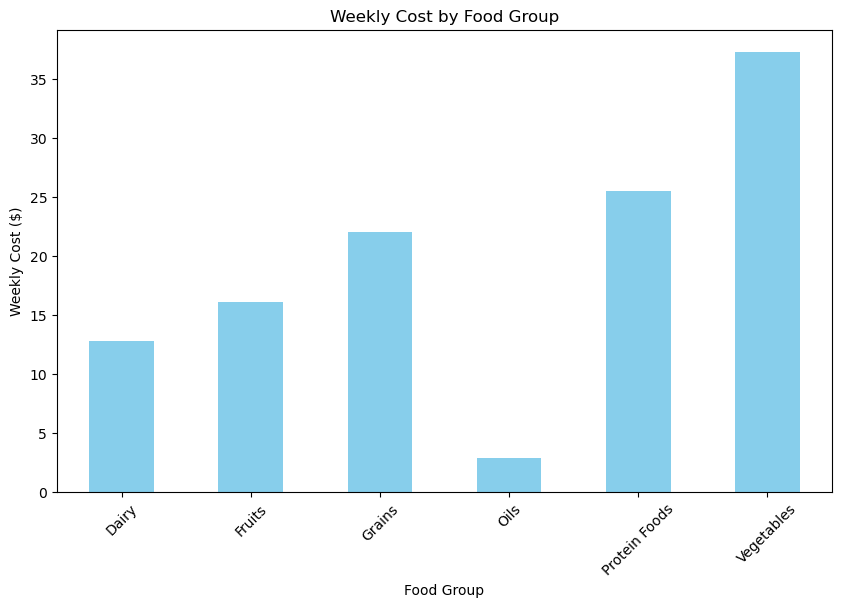

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Aggregate weekly cost by food group
weekly_cost_by_group = data.groupby('Food_Group')['weekly_cost'].sum()

# Plot
weekly_cost_by_group.plot(kind='bar', color='skyblue', figsize=(10, 6))
plt.title('Weekly Cost by Food Group')
plt.xlabel('Food Group')
plt.ylabel('Weekly Cost ($)')
plt.xticks(rotation=45) # Rotates the labels on the x-axis for better readability

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'${height:.2f}', ha='center', va='bottom')

plt.show()


From the histogram above we can see that vegetables and protein foods are the most expensive group of products, while oils and dairy comparatively cheaper. It leads to the situation that people prefer cheaper products due to a shortage of funds, so have an unbalanced and unhealthy diet with overconsumption of fats and carbohydrates and a shortage of proteins and dietary fiber.

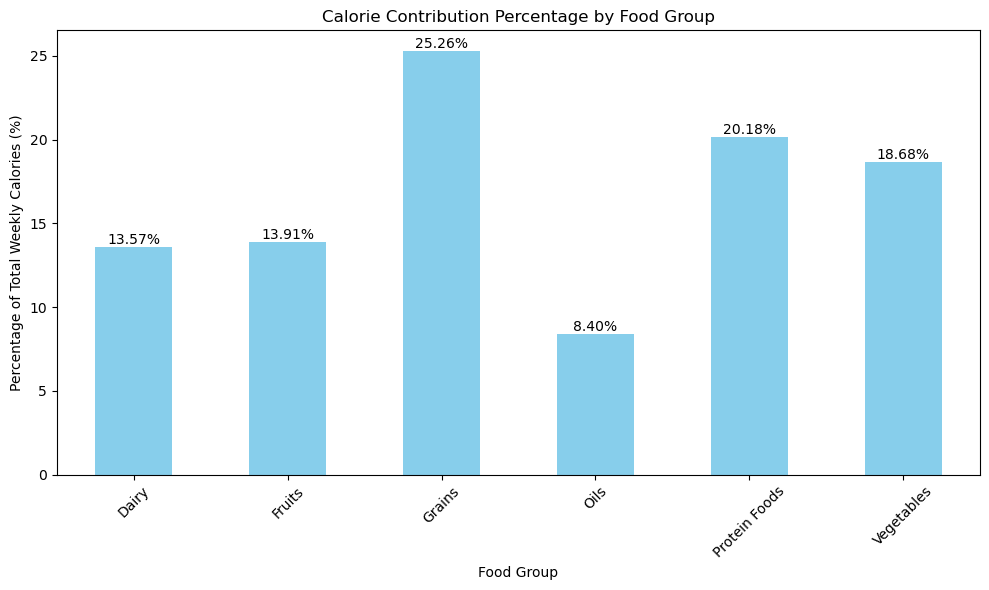

In [15]:
# Calculate the total weekly caloric intake by food group
total_weekly_calories_by_group = data.groupby('Food_Group')['Daily_Calorie_Estimate'].sum()

# Calculate the total weekly caloric intake across all items
total_weekly_calories = total_weekly_calories_by_group.sum()

# Calculate the percentage contribution of each food group
calorie_contribution_percentage = (total_weekly_calories_by_group / total_weekly_calories) * 100

# Visualization
calorie_contribution_percentage.plot(kind='bar', color='skyblue', figsize=(10, 6))
plt.title('Calorie Contribution Percentage by Food Group')
plt.xlabel('Food Group')
plt.ylabel('Percentage of Total Weekly Calories (%)')
plt.xticks(rotation=45)

for index, value in enumerate(calorie_contribution_percentage):
    plt.text(index, value, f'{value:.2f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()


On the given histogram we can see the distribution of calories in each group of food products. Based on this information and the previous graph we can conclude that an unbalanced diet based on cheaper products leads to the overconsumption of calories and therefore increases the probability of obesity.

In [16]:
# Import the pandas library
import pandas as pd

# Calculate the cost per calorie for each item
data['Cost_per_Calorie'] = data['weekly_cost'] / data['Daily_Calorie_Estimate']

# Find the items with the lowest cost per calorie
lowest_cost_per_calorie_items = data.sort_values(by='Cost_per_Calorie').head()

# Calculate the average cost per calorie by food group
average_cost_per_calorie_by_group = data.groupby('Food_Group')['Cost_per_Calorie'].mean()

# Print the items with the lowest cost per calorie and the average cost per calorie by food group
print(lowest_cost_per_calorie_items[['Item', 'Cost_per_Calorie']])
print(average_cost_per_calorie_by_group)


                 Item  Cost_per_Calorie
23          Olive oil          0.001645
30            Bananas          0.001734
28  Whole wheat bread          0.002750
19    Sunflower seeds          0.002898
22        Avocado oil          0.003137
Food_Group
Dairy            0.005839
Fruits           0.008157
Grains           0.006123
Oils             0.002391
Protein Foods    0.009287
Vegetables       0.028314
Name: Cost_per_Calorie, dtype: float64


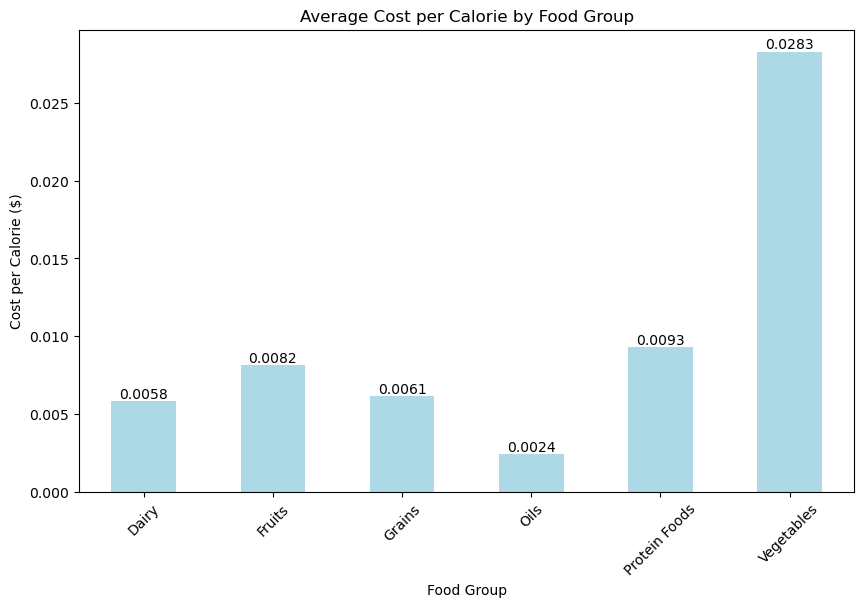

In [17]:
average_cost_per_calorie_by_group.plot(kind='bar', color='lightblue', figsize=(10, 6))

plt.title('Average Cost per Calorie by Food Group')
plt.xlabel('Food Group')
plt.ylabel('Cost per Calorie ($)')
plt.xticks(rotation=45) 

# Loop over the bars and add text labels
for index, value in enumerate(average_cost_per_calorie_by_group):
    plt.text(index, value, f'{value:.4f}', ha='center', va='bottom')

plt.show()



C:\Users\softe\AppData\Local\Temp\ipykernel_30656\1503735501.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Caloric_Density'] = data_filtered['Daily_Calorie_Estimate'] / data_filtered['Quantity_for_One_Week_metric']


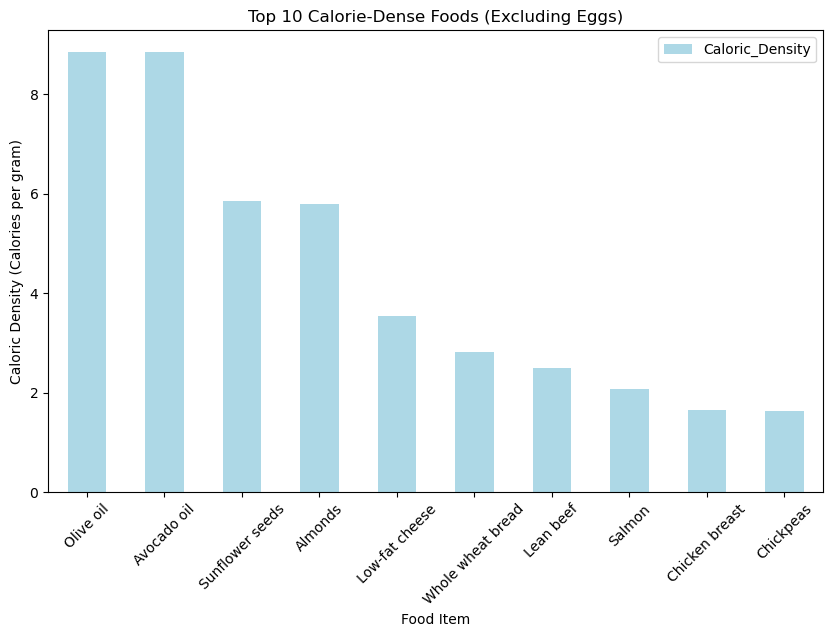

In [18]:
# Exclude "eggs" from the dataset due to its unique unite of measurement (per egg)
data_filtered = data[data['Item'].str.lower() != 'eggs']  # This assumes 'Item' contains the name, adjust if needed

# Calculate caloric density (calories per gram) for the filtered data
data_filtered['Caloric_Density'] = data_filtered['Daily_Calorie_Estimate'] / data_filtered['Quantity_for_One_Week_metric']

# Sort the data by caloric density in descending order to find the most calorie-dense foods
caloric_density_sorted = data_filtered.sort_values(by='Caloric_Density', ascending=False)

# plot the top 10 most calorie-dense foods from the filtered dataset
top_caloric_density = caloric_density_sorted.head(10)
top_caloric_density.plot(kind='bar', x='Item', y='Caloric_Density', color='lightblue', figsize=(10, 6))
plt.title('Top 10 Calorie-Dense Foods (Excluding Eggs)')
plt.xlabel('Food Item')
plt.ylabel('Caloric Density (Calories per gram)')
plt.xticks(rotation=45)
plt.show()


The current minimum wage for Massachusetts state is 15 USD/hour. However, there were some political campaigns to increase the minimum wage in Massachusetts state to USD 20 based on inflation, even though this state has one of the highest minimum salaries in the country (Most 2024). So, in our analysis we would consider is the decision to save the minimum salary to the level of USD 15 was correct or whether the activists argued that people need higher salaries in Massachusetts to survive were right.

In [19]:
# Constants
hourly_wage = 15  # dollars per hour
hours_per_week = 40  # hours

# Calculate weekly income
weekly_income = hourly_wage * hours_per_week
weekly_income


600

Based on simple calculation (wage per hour * standard working hours per week) we calculated that minimum weekly income is $600.

Then we got data about regular expenses in Boston from the Boston University website and Forbes Advisor calculator and rent expenses for the suburb of Boston.


In [20]:
# Constants
monthly_rent = 1000  # dollars
Utilities = 302.72 + 187.85 # energy plus phone bills from Forbes monthly expences calculator 
transportation = 1120 / 9 # from Boston university data
healthcare = 137.73 # calculated as one visit to dantist, one to Optometrist, one to another doctor, one Prescription Drug, one ibuprofen in 6 months
personal = 3292 / 9 # from Boston university data
tax = weekly_income * 0.05

# Calculate total monthly costs
total_monthly_costs = monthly_rent + Utilities + transportation + healthcare + personal + tax

# Convert monthly costs to weekly costs
weekly_total_costs = total_monthly_costs / 4.345  # Assuming 4.345 weeks per month in average
weekly_total_costs


494.4815241017773

Then we calculated the weekly cost based on the average monthly rent plus the monthly cost without rent and divided it by the average number of weeks in a month.

Then we used food data obtained from scrapping and calculated the total weekly food cost.


In [21]:
# Calculate the total weekly food cost from the previously loaded data
total_weekly_food_cost = data['weekly_cost'].sum()
total_weekly_food_cost


116.52380961442455

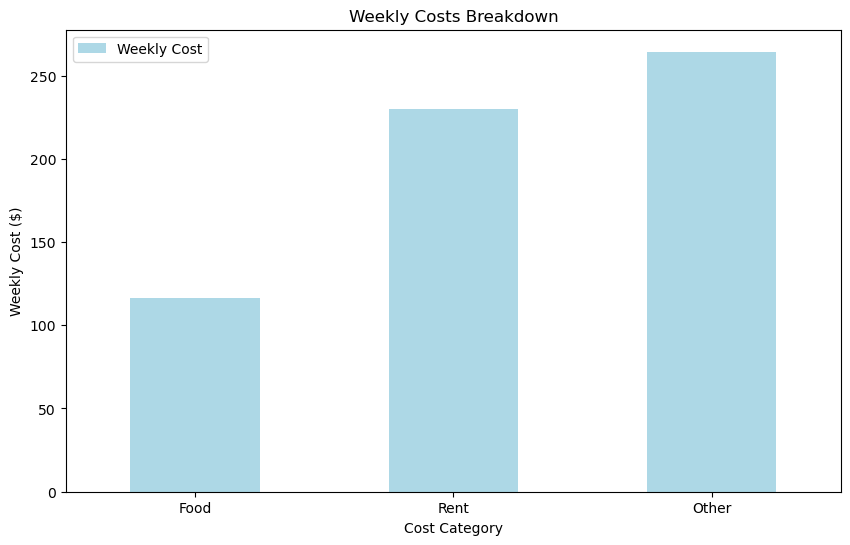

In [22]:
# Weekly rent cost ( 4.345 weeks per month  )
weekly_rent_cost = monthly_rent / 4.345

# Weekly other costs (excluding food and rent,  the other monthly costs are evenly divided by 4.345 weeks)
weekly_other_costs = (Utilities + transportation + healthcare + tax + personal) / 4.345

# Data for visualization
weekly_costs_data = {
    'Category': ['Food', 'Rent', 'Other'],
    'Weekly Cost': [total_weekly_food_cost, weekly_rent_cost, weekly_other_costs]
}

weekly_costs_df = pd.DataFrame(weekly_costs_data)

# Visualization
weekly_costs_df.plot(kind='bar', x='Category', y='Weekly Cost', color='lightblue', figsize=(10, 6))
plt.title('Weekly Costs Breakdown')
plt.xlabel('Cost Category')
plt.ylabel('Weekly Cost ($)')
plt.xticks(rotation=0)  
plt.show()


In [23]:

total_weekly_food_cost_correct = 116.52

# Calculate the remaining balance after each type of expense
remaining_after_food = weekly_income - total_weekly_food_cost_correct
remaining_after_rent = remaining_after_food - weekly_rent_cost
remaining_after_other = remaining_after_rent - weekly_other_costs

# Preparing data for visualization
categories_correct = ['Initial Income', 'After Food', 'After Rent', 'After Other']
balances_correct = [weekly_income, remaining_after_food, remaining_after_rent, remaining_after_other]

# Creating DataFrame for visualization
weekly_balance_df_correct = pd.DataFrame({
    'Category': categories_correct,
    'Balance': balances_correct
})


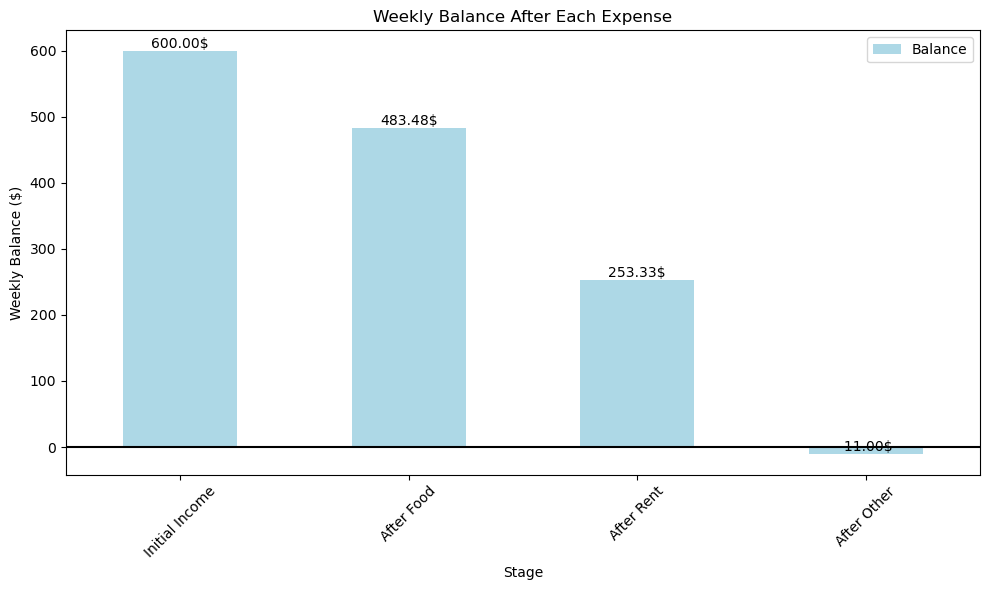

In [24]:

weekly_balance_df_correct.plot(kind='bar', x='Category', y='Balance', color='lightblue', figsize=(10, 6))
plt.title('Weekly Balance After Each Expense')
plt.xlabel('Stage')
plt.ylabel('Weekly Balance ($)')
plt.xticks(rotation=45)
plt.axhline(y=0, color='k', linestyle='-')  # Reference line at y=0

# Adding value labels on top of the bars
for index, value in enumerate(balances_correct):
    plt.text(index, value, f'{value:.2f}$', ha='center', va='bottom' if value < 0 else 'bottom')

plt.tight_layout()
plt.show()


If we increase minimum wage till 16 USD /hour:

In [25]:
# Constants
new_hourly_wage = 16  # dollars per hour
hours_per_week = 40  # hours

# Calculate weekly income
new_weekly_income = new_hourly_wage * hours_per_week
new_weekly_income

640

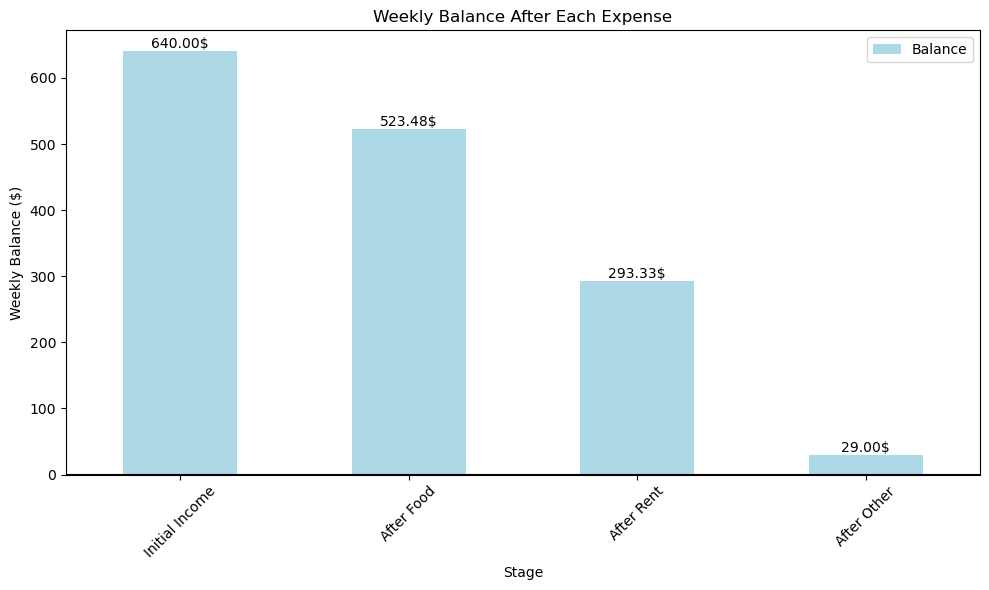

In [26]:
# Calculate the remaining balance after each type of expense
remaining_after_food = new_weekly_income - total_weekly_food_cost_correct
remaining_after_rent = remaining_after_food - weekly_rent_cost
remaining_after_other = remaining_after_rent - weekly_other_costs

# Preparing data for visualization
categories_correct = ['Initial Income', 'After Food', 'After Rent', 'After Other']
balances_correct = [new_weekly_income, remaining_after_food, remaining_after_rent, remaining_after_other]

# Creating DataFrame for visualization
weekly_balance_df_correct = pd.DataFrame({
    'Category': categories_correct,
    'Balance': balances_correct
})

# Visualization
weekly_balance_df_correct.plot(kind='bar', x='Category', y='Balance', color='lightblue', figsize=(10, 6))
plt.title('Weekly Balance After Each Expense')
plt.xlabel('Stage')
plt.ylabel('Weekly Balance ($)')
plt.xticks(rotation=45)
plt.axhline(y=0, color='k', linestyle='-')  # Reference line at y=0

# Adding value labels on top of the bars
for index, value in enumerate(balances_correct):
    plt.text(index, value, f'{value:.2f}$', ha='center', va='bottom' if value < 0 else 'bottom')

plt.tight_layout()
plt.show()

Based on our analysis we can conclude that the current level of minimum wage in Boston is not enough to maintain a healthy diet. Considering that all other costs are fixed and only food costs are variable, we can assume that people will try to cut their variable costs to survive. In other words, they will try to buy cheaper products to have enough money to pay rent, utilities, and transport costs. Based on our analysis above it will lead to high consumption of oils, grain, and dairy, while consumption of proteins and vegetables will decrease, which can result in high levels of cholesterol and sugar that will lead to further obesity, diabetes type 2 and cardiovascular diseases. Therefore, we agree with the proposal to increase the minimum wage in Massachusetts state or separately for Boston City to 16 USD / hour considering the current cost of living in Boston.


# Specific vulnerable groups

We also consider some vulnerable groups that have higher expenses or could not receive even a minimum wage. They are single parents, workers with tips and students.

## Single parents

In [27]:
calorie_intake=2255*7 
cal_kid=1200*7 #According to a dietary guidelines the neccessary calorie intake for a child in the age 3-4 years
price_kid=(cal_kid*total_weekly_food_cost_correct)/calorie_intake
price_per_meal=price_kid/(7*3) #Calculating price per meal
meals_at_home=(5*7)*price_per_meal #Taking into account dinners and meals during weekends

In [28]:
#Expenses related to a child
childcare=(330/30)*7 #subsidezed  price for childacare for low-income families. The price parents need to pay calculated for a week
meals_in_daycare=2*2*5*price_per_meal #2 meals in a day with a subsidized price of 2$ per meal for 5 work days
print ("childcare =", childcare)

childcare = 77.0


In [29]:
SNAP_benefits=(220/30)*7 #Amounts provided by a government to a single parrent to cover expenses related to a child. 

In [30]:
print(meals_at_home)
print(meals_in_daycare)

103.34368070953437
59.05353183401964


In [31]:
# Calculate the remaining balance after each type of expense in a scenario of a single parrent with a 3-4 year old child
remaining_after_food = weekly_income - total_weekly_food_cost_correct
remaining_after_rent = remaining_after_food - weekly_rent_cost
remaining_after_other = remaining_after_rent - weekly_other_costs
remaining_with_snap = remaining_after_other + SNAP_benefits 
remaining_after_child_expenses = remaining_with_snap - childcare - meals_in_daycare - meals_at_home

# Preparing data for visualization
categories_correct = ['Initial Income', 'After Food', 'After Rent', 'After Other', 'With SNAP','After child expenses']
balances_correct = [weekly_income, remaining_after_food, remaining_after_rent, remaining_after_other,remaining_with_snap,remaining_after_child_expenses ]

# Creating DataFrame for visualization
weekly_balance_df_correct = pd.DataFrame({
    'Category': categories_correct,
    'Balance': balances_correct
})


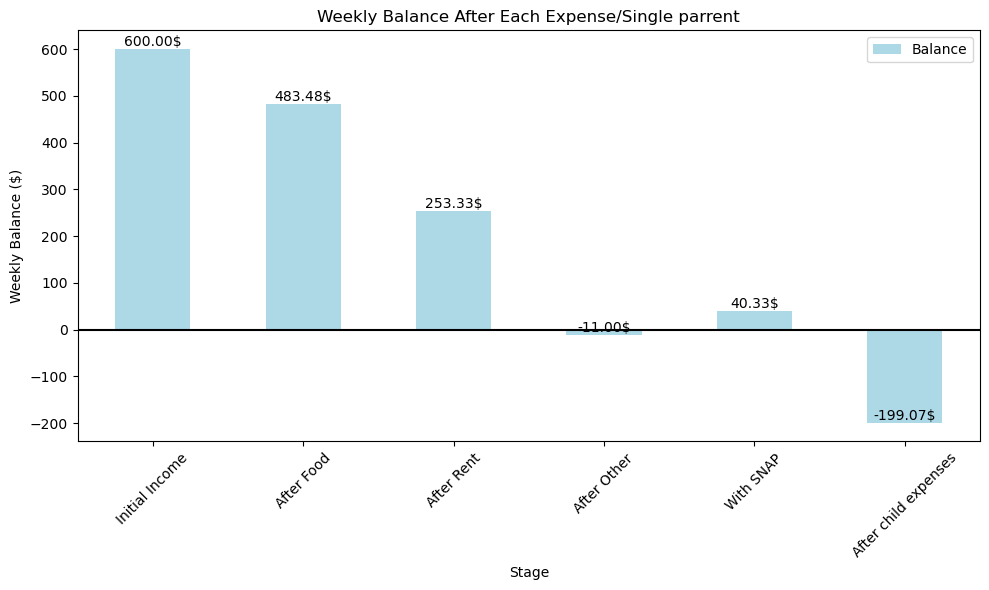

In [32]:
# Visualization of the weekly balance after each expense for a single parent with a 3-4 year old child

weekly_balance_df_correct.plot(kind='bar', x='Category', y='Balance', color='lightblue', figsize=(10, 6))
plt.title('Weekly Balance After Each Expense/Single parrent')
plt.xlabel('Stage')
plt.ylabel('Weekly Balance ($)')
plt.xticks(rotation=45)
plt.axhline(y=0, color='k', linestyle='-')  # Reference line at y=0

# Adding value labels on top of the bars
for index, value in enumerate(balances_correct):
    plt.text(index, value, f'{value:.2f}$', ha='center', va='bottom' if value < 0 else 'bottom')

plt.tight_layout()
plt.show()


If we increase minimum wage till 16 USD/hour and SNAP increased till 905 USD/month:

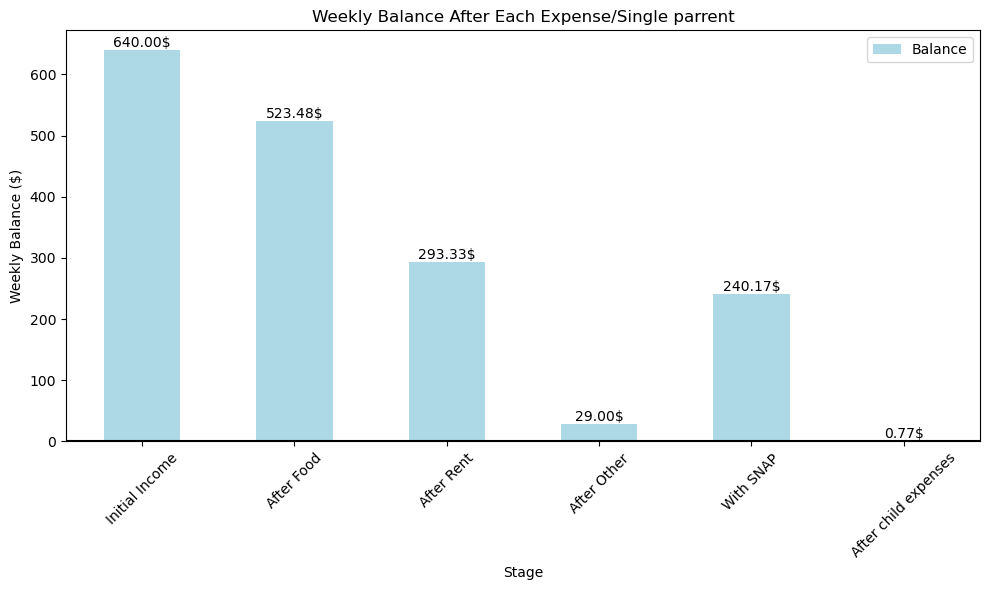

In [40]:
SNAP_benefits=(905/30)*7 

# Calculate the remaining balance after each type of expense in a scenario of a single parrent with a 3-4 year old child
remaining_after_food = new_weekly_income - total_weekly_food_cost_correct
remaining_after_rent = remaining_after_food - weekly_rent_cost
remaining_after_other = remaining_after_rent - weekly_other_costs
remaining_with_snap = remaining_after_other + SNAP_benefits 
remaining_after_child_expenses = remaining_with_snap - childcare - meals_in_daycare - meals_at_home

# Preparing data for visualization
categories_correct = ['Initial Income', 'After Food', 'After Rent', 'After Other', 'With SNAP','After child expenses']
balances_correct = [new_weekly_income, remaining_after_food, remaining_after_rent, remaining_after_other,remaining_with_snap,remaining_after_child_expenses ]

# Creating DataFrame for visualization
weekly_balance_df_correct = pd.DataFrame({
    'Category': categories_correct,
    'Balance': balances_correct
})

# Visualization of the weekly balance after each expense for a single parent with a 3-4 year old child

weekly_balance_df_correct.plot(kind='bar', x='Category', y='Balance', color='lightblue', figsize=(10, 6))
plt.title('Weekly Balance After Each Expense/Single parrent')
plt.xlabel('Stage')
plt.ylabel('Weekly Balance ($)')
plt.xticks(rotation=45)
plt.axhline(y=0, color='k', linestyle='-')  # Reference line at y=0

# Adding value labels on top of the bars
for index, value in enumerate(balances_correct):
    plt.text(index, value, f'{value:.2f}$', ha='center', va='bottom' if value < 0 else 'bottom')

plt.tight_layout()
plt.show()


Although the Massachusetts Supplemental Nutrition Assistance Program, subsidized childcare, and subsidized meals in daycare for low-income families offer some benefits, it is still difficult for single parent earning minimum wage to afford healthy meals for themselves and their children. As shown in the graph, the household budget falls short by $199 even after accounting for all necessary expenses. This deficit does not include any unforeseen expenses that may arise. This situation highlights the urgent need for policymakers to reevaluate and improve the support systems available to low-income families, ensuring that they have adequate resources to meet their nutritional and basic living needs without facing such precarious financial shortfalls.
Therefore, we suggest not only increasing the minimum wage to 16 USD / hour but also increasing the SNAP value to 905 USD / month.

## Workers with tips

Workers with tips from USD 20 in a month get $6.75 per hour. We will calculate the same numbers as above for workers with tips.

In [41]:
# Constants
hourly_wage = 6.75  # dollars per hour
hours_per_week = 40  # hours

# Calculate weekly income with $20 tips
weekly_income = hourly_wage * hours_per_week + 20
weekly_income


290.0

In [42]:
# Define corrected amounts
total_weekly_food_cost_correct = 116.52

# Calculate the remaining balance after each type of expense
remaining_after_food = weekly_income - total_weekly_food_cost_correct
remaining_after_rent = remaining_after_food - weekly_rent_cost
remaining_after_other = remaining_after_rent - weekly_other_costs

# Preparing data for visualization
categories_correct = ['Initial Income', 'After Food', 'After Rent', 'After Other']
balances_correct = [weekly_income, remaining_after_food, remaining_after_rent, remaining_after_other]

# Creating DataFrame for visualization
weekly_balance_df_correct = pd.DataFrame({
    'Category': categories_correct,
    'Balance': balances_correct
})


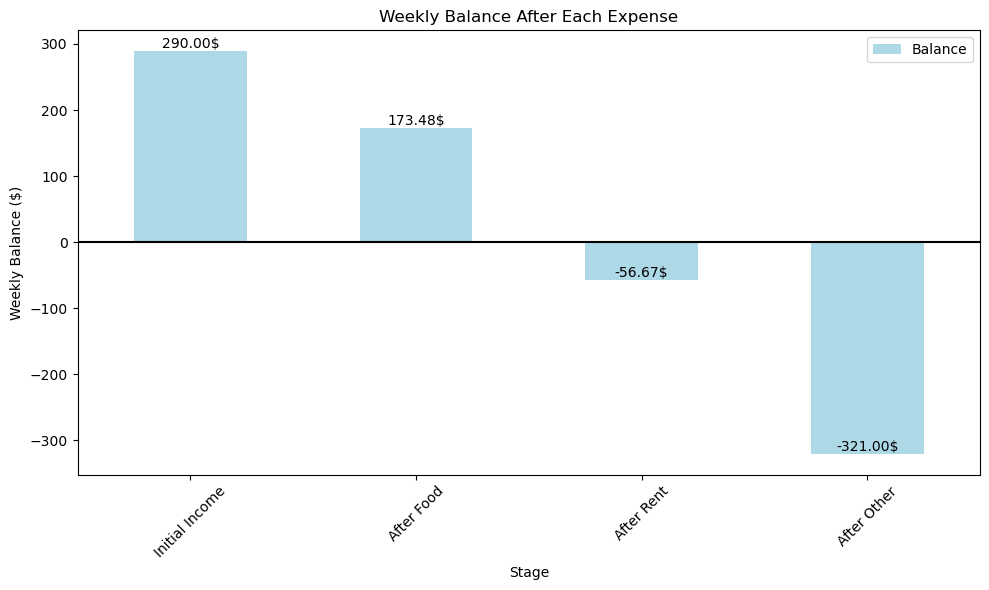

In [43]:
# Visualization 

weekly_balance_df_correct.plot(kind='bar', x='Category', y='Balance', color='lightblue', figsize=(10, 6))
plt.title('Weekly Balance After Each Expense')
plt.xlabel('Stage')
plt.ylabel('Weekly Balance ($)')
plt.xticks(rotation=45)
plt.axhline(y=0, color='k', linestyle='-')  # Reference line at y=0

# Adding value labels on top of the bars
for index, value in enumerate(balances_correct):
    plt.text(index, value, f'{value:.2f}$', ha='center', va='bottom' if value < 0 else 'bottom')

plt.tight_layout()
plt.show()


We can see that workers with tips do not earn enough money to survive if they get only minimum tips, so we suggest either increasing their minimum wage to standard rates or creating subgroups based on tips amount.

## Students

Students in the Massachusetts state can not work more than 20 hours per week during school sessions according to internal policies of many universities and USCIS regulations. Moreover there are some specific minumum wage subgoups for trainees and early -careers, which get lower salary for the first 3 months of working or learning period. However, we will consider only students with normal 15 USD per hour minimum wage working 20 hours in a week.

In [44]:
# Constants
hourly_wage = 15  # dollars per hour
hours_per_week = 20  # hours

# Calculate weekly income with $20 tips, 
weekly_income = hourly_wage * hours_per_week
weekly_income


300

For the calculation of the student expenses, we used data from Boston University ("Boston University Housing"), ("Cost of Attendance for 2024-2025"). We did not use Boston University's dining plan because our dining plan based on scrapping is cheaper, so we assume that students would prefer a cheaper option

In [46]:
# Constants
monthly_rent = 11600 / 9  # dollars on campus including utilities
transportation = 1120 / 9 # from Boston university data
books = 1264 / 9 # from Boston university data
healthcare = (956 + 11.39) / 9  # calculated as Boston University healthcare service fee plus one ibuprofen in 9 months ption Drug, one ibuprofen in 6 months
personal = 3292 / 9 # from Boston university data
tax = weekly_income * 0.05

# Calculate total monthly costs
total_monthly_costs = monthly_rent + transportation + books + healthcare + personal + tax

# Convert monthly costs to weekly costs
weekly_total_costs = total_monthly_costs / 4.345  # Assuming 4.345 weeks per month in average
weekly_total_costs


469.975450709628

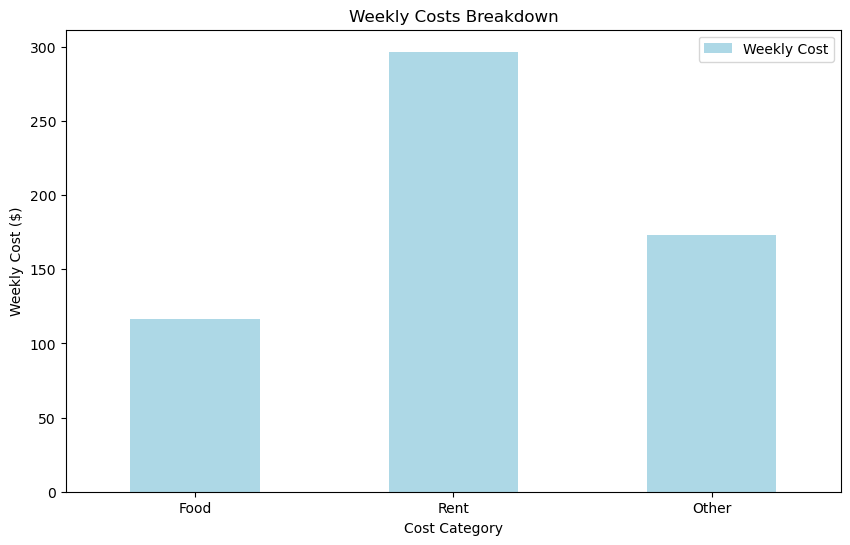

In [47]:
# Weekly rent cost ( the monthly rent is evenly divided by 4.345 weeks)
weekly_rent_cost = monthly_rent / 4.345

# Weekly other costs (excluding food and rent, assuming the other monthly costs are evenly divided by 4.345 weeks)
weekly_other_costs = (transportation + books + healthcare + personal + tax) / 4.345

# Data for visualization
weekly_costs_data = {
    'Category': ['Food', 'Rent', 'Other'],
    'Weekly Cost': [total_weekly_food_cost, weekly_rent_cost, weekly_other_costs]
}

weekly_costs_df = pd.DataFrame(weekly_costs_data)

# Visualization
weekly_costs_df.plot(kind='bar', x='Category', y='Weekly Cost', color='lightblue', figsize=(10, 6))
plt.title('Weekly Costs Breakdown')
plt.xlabel('Cost Category')
plt.ylabel('Weekly Cost ($)')
plt.xticks(rotation=0)  # Keep the category names horizontal for readability
plt.show()

In [48]:
# Define corrected amounts
total_weekly_food_cost_correct = 116.52

# Calculate the remaining balance after each type of expense
remaining_after_food = weekly_income - total_weekly_food_cost_correct
remaining_after_rent = remaining_after_food - weekly_rent_cost
remaining_after_other = remaining_after_rent - weekly_other_costs

# Preparing data for visualization
categories_correct = ['Initial Income', 'After Food', 'After Rent', 'After Other']
balances_correct = [weekly_income, remaining_after_food, remaining_after_rent, remaining_after_other]

# Creating DataFrame for visualization
weekly_balance_df_correct = pd.DataFrame({
    'Category': categories_correct,
    'Balance': balances_correct
})


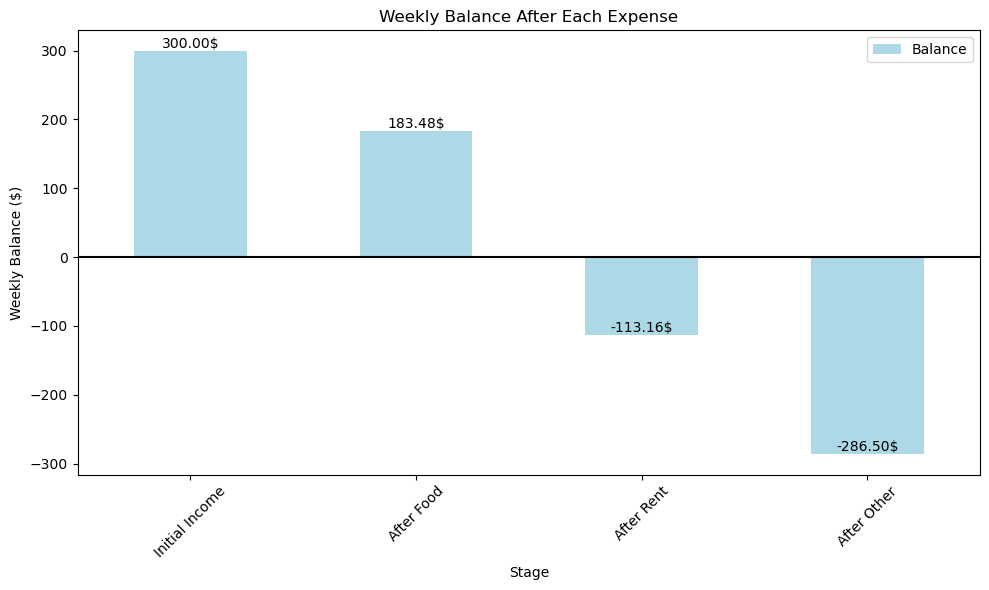

In [49]:
# Visualization 

weekly_balance_df_correct.plot(kind='bar', x='Category', y='Balance', color='lightblue', figsize=(10, 6))
plt.title('Weekly Balance After Each Expense')
plt.xlabel('Stage')
plt.ylabel('Weekly Balance ($)')
plt.xticks(rotation=45)
plt.axhline(y=0, color='k', linestyle='-')  # Reference line at y=0

# Adding value labels on top of the bars
for index, value in enumerate(balances_correct):
    plt.text(index, value, f'{value:.2f}$', ha='center', va='bottom' if value < 0 else 'bottom')

plt.tight_layout()
plt.show()

We can see that students also cannot earn enough money for a comfortable living, so they would probably cut their food costs as in previous groups. However, even such a decision will not help them to survive because they earn almost twice less as they spend. In this case, the only optimal decision for a student is an additional source of money for the period of studying, such as a scholarship, financial support from parents or relatives or a student loan. In other cases, students will not be able to pay their bills. Moreover, these amounts do not include tuition fees, which are also high. So, any students without additional sources of money (including international students) will not be able to study at the university even if they are accepted which makes the university education a luxury service. We would suggest such policy implications as increasing the number of scholarships and student loans for talented students to allow them to get a better education and make further input in world development. 
We also consider further research in this area, such as the calculation of student funds with student loans and scholarships to analyze if their amounts are enough to have a healthy diet and quality of life.


# Conclusion

Based on our analysis we concluded that the current minimum wage is not enough to have a healthy diet in Boston for all general groups, single parents, workers with tips and students. We suggest increasing the minimum wage to 16 USD/hour for Boston city and increasing SNAP for single parents to 790 USD / month, additionally, for workers with tips we suggest adding specific subgroups based on the number of tips received and for students, we suggest increasing the number of scholarship and student loans. 

There are some potential topics for further research on the related issues such as Boston housing market scrapping, and analyzing the food prices in other regions of the USA which can supplement the research results and provide a deeper analysis of the given topic.


## References: 

Ben’s Natural Health. "Standard American Diet: Risks & Side Effects." Accessed March 28, 2024. https://www.bensnaturalhealth.com/blog/general-health/standard-american-diet/. 

U.S. Department of Agriculture and U.S. Department of Health and Human Services. "Dietary Guidelines for Americans 2020-2025." Physicians Committee for Responsible Medicine. Accessed March 28, 2024. https://www.pcrm.org/good-nutrition/nutrition-programs-policies/2020-2025-dietary-guidelines. 

Wang, Runjing, Katherine Nelson, and Sean A. Munson. "Large-scale diet tracking data reveal disparate associations between food environment and diet." Nature Communications 12, no. 1 (2021): 1-10. Accessed March 28, 2024. https://www.nature.com/articles/s41467-021-27522-y/. 

Most, Doug. "Is Today’s Minimum Wage an Honest Living Wage?" Boston University, February 6, 2024. Accessed April 19, 2024. https://www.bu.edu/articles/2024/is-todays-minimum-wage-an-honest-living-wage/. 

"Massachusetts Law about Minimum Wage." Mass.gov. Accessed April 19, 2024. URL: https://www.mass.gov/info-details/massachusetts-law-about-minimum-wage 

Forbes. (n.d.). Cost of living calculator: Boston, MA vs. Fairbanks, AK. Accessed April 24, 2024. Retrieved from https://www.forbes.com/advisor/mortgages/real-estate/cost-of-living-calculator/boston-ma/?city=fairbanks-ak&income=31284 

Boston University College of Arts & Sciences. (n.d.). Cost of Attendance for 2024-2025. Accessed April 24, 2024. Retrieved from https://www.bu.edu/cas/admissions/ma-ms/financial-aid/cost-of-attendance/ 

"Cost of Attendance for 2024-2025." Boston University College of Arts & Sciences, Accessed April 19, 2024. https://www.bu.edu/cas/admissions/ma-ms/financial-aid/cost-of-attendance/. 

"Boston University Housing." Boston University Housing. Accessed April 19, 2024. https://www.bu.edu/housing/. 

The Online Resource for Massachusetts Poverty Law Advocates https://www.masslegalservices.org/content/online-snap-calculator

Rental Listings in Boston, MA." Zillow. Accessed April 24, 2024. https://www.zillow.com/boston-ma/rentals/?searchQueryState=%7B%22pagination%22%3A%7B%7D%2C%22isMapVisible%22%3Atrue%2C%22mapBounds%22%3A%7B%22west%22%3A-71.13784530046061%2C%22east%22%3A-71.05149962785319%2C%22south%22%3A42.330260066423726%2C%22north%22%3A42.380621196663796%7D%2C%22regionSelection%22%3A%5B%7B%22regionId%22%3A44269%2C%22regionType%22%3A6%7D%5D%2C%22filterState%22%3A%7B%22fr%22%3A%7B%22value%22%3Atrue%7D%2C%22fsba%22%3A%7B%22value%22%3Afalse%7D%2C%22fsbo%22%3A%7B%22value%22%3Afalse%7D%2C%22nc%22%3A%7B%22value%22%3Afalse%7D%2C%22cmsn%22%3A%7B%22value%22%3Afalse%7D%2C%22auc%22%3A%7B%22value%22%3Afalse%7D%2C%22fore%22%3A%7B%22value%22%3Afalse%7D%2C%22sf%22%3A%7B%22value%22%3Afalse%7D%2C%22tow%22%3A%7B%22value%22%3Afalse%7D%2C%22mf%22%3A%7B%22value%22%3Afalse%7D%2C%22land%22%3A%7B%22value%22%3Afalse%7D%2C%22manu%22%3A%7B%22value%22%3Afalse%7D%2C%22beds%22%3A%7B%22min%22%3A1%7D%2C%22r4r%22%3A%7B%22value%22%3Atrue%7D%2C%22sort%22%3A%7B%22value%22%3A%22paymenta%22%7D%7D%2C%22isListVisible%22%3Atrue%2C%22mapZoom%22%3A14%7D 